In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import csv
import os

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.utils import load_img, array_to_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Constants 

In [2]:
random_state = 42
val_split_size = 0.2
training_mode = False 

### Extract Data from CSV to Numpy Arrays

In [3]:
def parse_data_from_csv_labels(filename):
  return np.loadtxt(filename, delimiter=',', skiprows=1, usecols=0).astype(np.float64)

def parse_data_from_csv_images(filename, end_range, start_range=1):
  images = np.loadtxt(filename, delimiter=',', skiprows=1, usecols=list(range(start_range, end_range))).astype(np.float64)
  images = np.reshape(images, (-1, 28, 28))
  images = np.expand_dims(images, -1)
  return images

def parse_data_from_csv(filename, labels_included = True): 
    with open(filename) as file:
        reader = csv.reader(file, delimiter=',')
        header = next(reader) 
        total_columns = len(header)
    if labels_included: 
        labels = parse_data_from_csv_labels(filename)
        images = parse_data_from_csv_images(filename, end_range=total_columns)
    else: 
        labels = np.array([])
        images = parse_data_from_csv_images(filename, start_range=0, end_range=total_columns)
    return images, labels
    

In [4]:
train_path = "/kaggle/input/digit-recognizer/train.csv"
total_images, total_labels = parse_data_from_csv(train_path)
print(f"train shape {total_images.shape}")

train shape (42000, 28, 28, 1)


In [5]:
unique = np.unique(total_labels)
print(f"unique labels {unique}")
print(f"count of unique labels {len(unique)}")

unique labels [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
count of unique labels 10


In [6]:
test_path = "/kaggle/input/digit-recognizer/test.csv"
test_images, test_labels = parse_data_from_csv(test_path, labels_included=False)
print(f"test shape {test_images.shape}")

test shape (28000, 28, 28, 1)


In [7]:
def plot_digits(images, labels=None, title="", section=0):
  number_of_rows = 3 
  number_of_cols = 4
    
  total_images = len(images)
  total_displayed = number_of_rows*number_of_cols
    
  start_value = total_displayed*section
  end_value = start_value + total_displayed

  fig, axes = plt.subplots(number_of_rows, number_of_cols, figsize=(12, 12))

  for index in range(start_value, end_value):
    img = images[index]
    plt.subplot(number_of_rows, number_of_cols, (index % total_displayed) + 1)
    plt.imshow(img)
    if labels is not None:
        plt.title(f"{labels[index].astype(int)}")

  plt.tight_layout()
  plt.suptitle(title)
  plt.show()

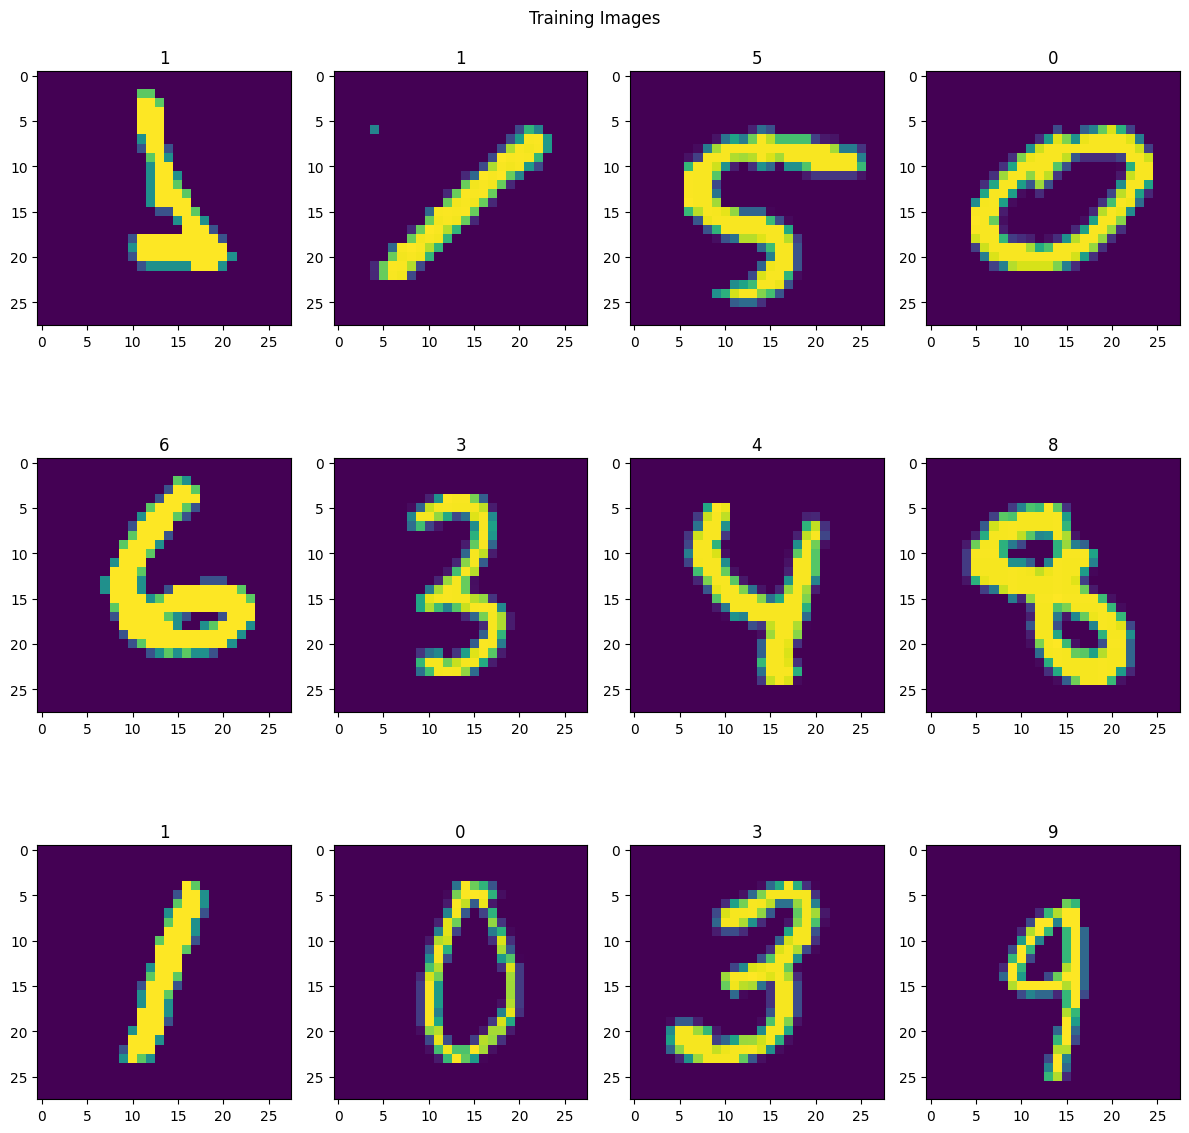

In [8]:
plot_digits(total_images, total_labels, title="Training Images", section=5)

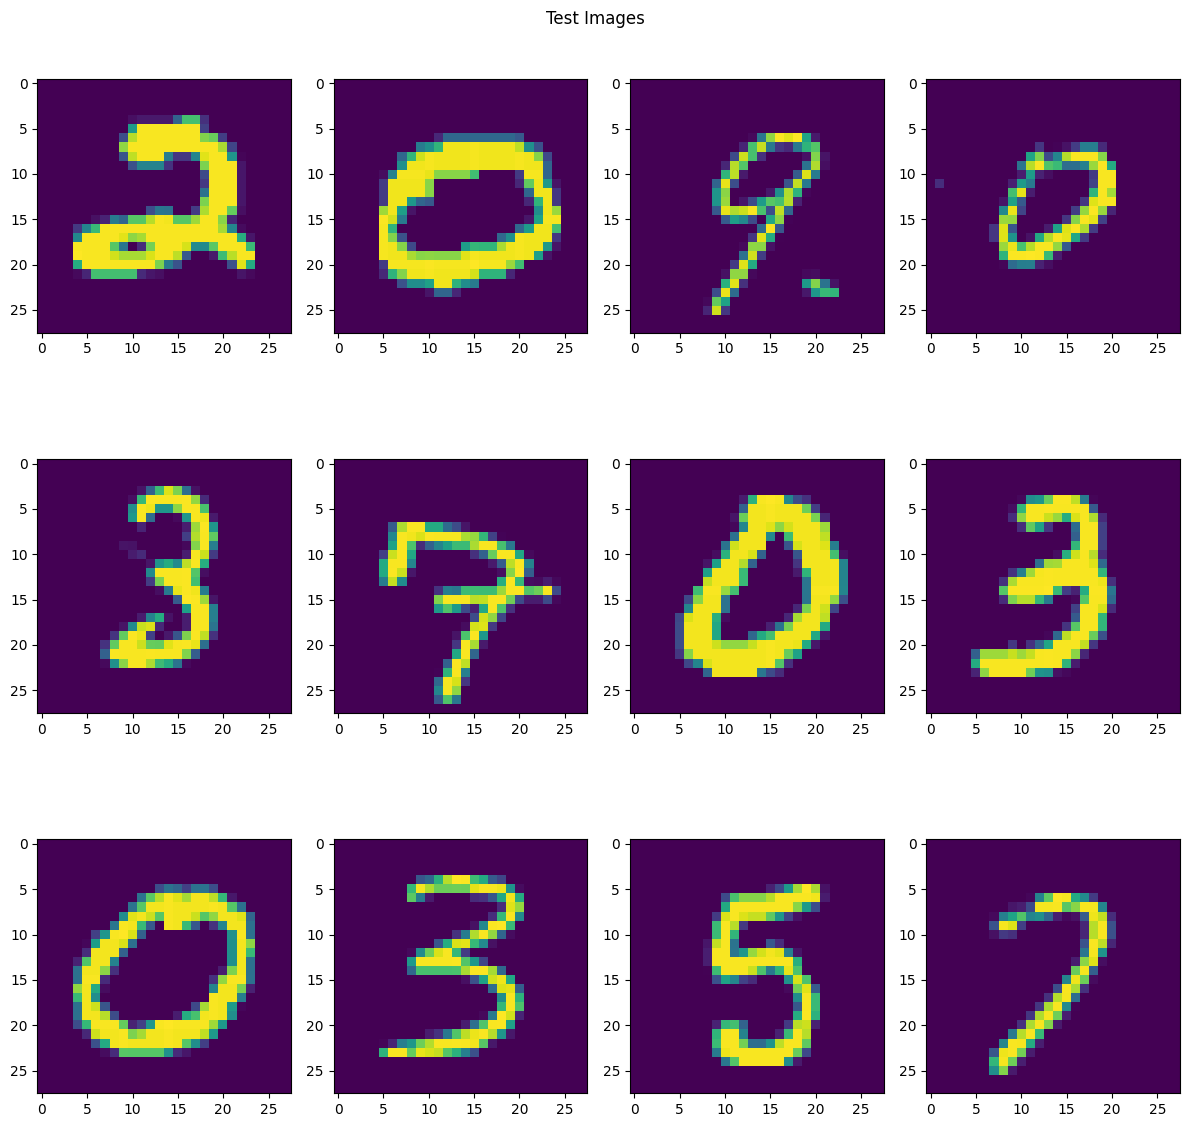

In [9]:
plot_digits(test_images, title="Test Images")

### Create ImageDataGenerators

In [10]:
def train_generator_creator(images, labels):

  train_datagen = ImageDataGenerator(
      rescale = 1./255,
      rotation_range=35,
      width_shift_range=0.1,
      height_shift_range=0.2,
      shear_range=0.3,
      fill_mode='constant', 
      cval=0)

  train_generator = train_datagen.flow(x=images,
                                       y=labels,
                                       batch_size=32)

  return train_generator

def val_generator_creator(images, labels, shuffle=True):

  validation_datagen = ImageDataGenerator(rescale = 1./255)

  validation_generator = validation_datagen.flow(x=images,
                                                 y=labels,
                                                 shuffle=shuffle,
                                                 batch_size=32)
  return validation_generator

def train_val_generator_creator(images, labels):
    images_train, images_val, label_train, label_val = train_test_split(images, labels, test_size=val_split_size, random_state=random_state)
    train_generator = train_generator_creator(images_train, label_train)
    validation_generator = val_generator_creator(images_val, label_val)
    return train_generator, validation_generator

def val_generator_non_shuffled_creator(images, labels):
    _, images_val, _, label_val = train_test_split(images, labels, test_size=val_split_size, random_state=random_state)
    return val_generator_creator(images_val, label_val, shuffle=False)

def total_generator_creator(images, labels): 
    return train_generator_creator(images, labels)

In [11]:
train_generator, validation_generator = train_val_generator_creator(total_images, total_labels)
total_generator = total_generator_creator(total_images, total_labels)

### Scale Test Data

In [12]:
rescale_layer = tf.keras.layers.Rescaling(1./255)
test_images = rescale_layer(test_images)

### Model

In [13]:
def create_model():

  model = tf.keras.models.Sequential([
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

  model.compile(optimizer = tf.keras.optimizers.Adam(),
                loss = 'sparse_categorical_crossentropy',
                metrics=['accuracy'])

  return model

In [14]:
model = create_model()

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 256)               4

In [15]:
def scheduler(epoch, lr):
    if epoch < 7:
        return lr
    else:
        return lr * tf.math.exp(-0.1)


learning_rate_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

if training_mode: 
    early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            restore_best_weights=True, 
                                            start_from_epoch=8,
                                            mode='min',
                                            patience=7)
    history = model.fit(train_generator,
                        epochs=100,
                        validation_data=validation_generator,
                        callbacks=[early_stop_callback, learning_rate_callback],
                        verbose=1)

### Plot Training and Validation History 

In [16]:
if training_mode: 
    history_df = pd.DataFrame(history.history)

In [17]:
if training_mode: 
    history_df.loc[:, ['loss', 'val_loss']].plot(title="Training and Validation loss")

In [18]:
if training_mode: 
    history_df = pd.DataFrame(history.history)
    history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title="Training and Validation accuracy")

In [19]:
#Best Epoch History 
if training_mode: 
    best_epoch = history_df['val_loss'].idxmin()
    best_epoch_history = history_df.iloc[best_epoch]
    print(f"best epoch {best_epoch}")
    print(best_epoch_history)

### Error Analysis: Look at images that were misclassified in the validation set

In [20]:
def get_predicted_digit(predictions): 
    return np.argmax(predictions, axis=1)

In [21]:
if training_mode: 
    val_generator_non_shuffled = val_generator_non_shuffled_creator(total_images, total_labels)

    val_predictions = model.predict(val_generator_non_shuffled)
    val_predictions = get_predicted_digit(val_predictions)
    val_true = val_generator_non_shuffled.y.astype(int)
    print(f"val predictions {val_predictions}")
    print(f"val true label {val_true}")

In [22]:
if training_mode: 
    val_label_df = pd.DataFrame({'val_pred': val_predictions,
                                'val_true': val_true})

In [23]:
if training_mode: 
    mislabeled_indices = val_label_df.index[val_label_df['val_pred'] != val_label_df['val_true']]
    print(mislabeled_indices)
    print(f"mislabeled count: {len(mislabeled_indices)}")

In [24]:
image_index = 0
max_images = 12

In [25]:
if training_mode: 
    image_index += max_images
    image_index %= len(mislabeled_indices)
    for i in range(image_index-max_images, image_index):
        plt.subplot(3, 4, (i % max_images) + 1)
        index = mislabeled_indices[i]
        img = val_generator_non_shuffled.x[index]
        correct_label=val_generator_non_shuffled.y[index]
        pred_label=val_predictions[index]
        plt.imshow(img)
        plt.title(f"P:{pred_label} C:{correct_label}")
        plt.axis('off')
    plt.suptitle("MisLabled Images")

    plt.show()

### Create Submission

In [26]:
if not training_mode:
    history = model.fit(total_generator,
                        epochs=20,
                        callbacks=[learning_rate_callback],
                        verbose=1)

Epoch 1/20
1313/1313 [==============================] - 32s 13ms/step - loss: 0.4199 - accuracy: 0.8628 - lr: 0.0010
Epoch 2/20
1313/1313 [==============================] - 17s 13ms/step - loss: 0.1505 - accuracy: 0.9532 - lr: 0.0010
Epoch 3/20
1313/1313 [==============================] - 17s 13ms/step - loss: 0.1198 - accuracy: 0.9624 - lr: 0.0010
Epoch 4/20
1313/1313 [==============================] - 17s 13ms/step - loss: 0.0986 - accuracy: 0.9695 - lr: 0.0010
Epoch 5/20
1313/1313 [==============================] - 18s 13ms/step - loss: 0.0900 - accuracy: 0.9724 - lr: 0.0010
Epoch 6/20
1313/1313 [==============================] - 17s 13ms/step - loss: 0.0831 - accuracy: 0.9737 - lr: 0.0010
Epoch 7/20
1313/1313 [==============================] - 17s 13ms/step - loss: 0.0772 - accuracy: 0.9756 - lr: 0.0010
Epoch 8/20
1313/1313 [==============================] - 17s 13ms/step - loss: 0.0666 - accuracy: 0.9791 - lr: 9.0484e-04
Epoch 9/20
1313/1313 [==============================] - 17s 

In [27]:
test_predictions = model.predict(test_images) 
test_predictions = get_predicted_digit(test_predictions)
print(f"test predictions example: {test_predictions[:5]}")

875/875 [==============================] - 1s 2ms/step
test predictions example: [2 0 9 0 3]


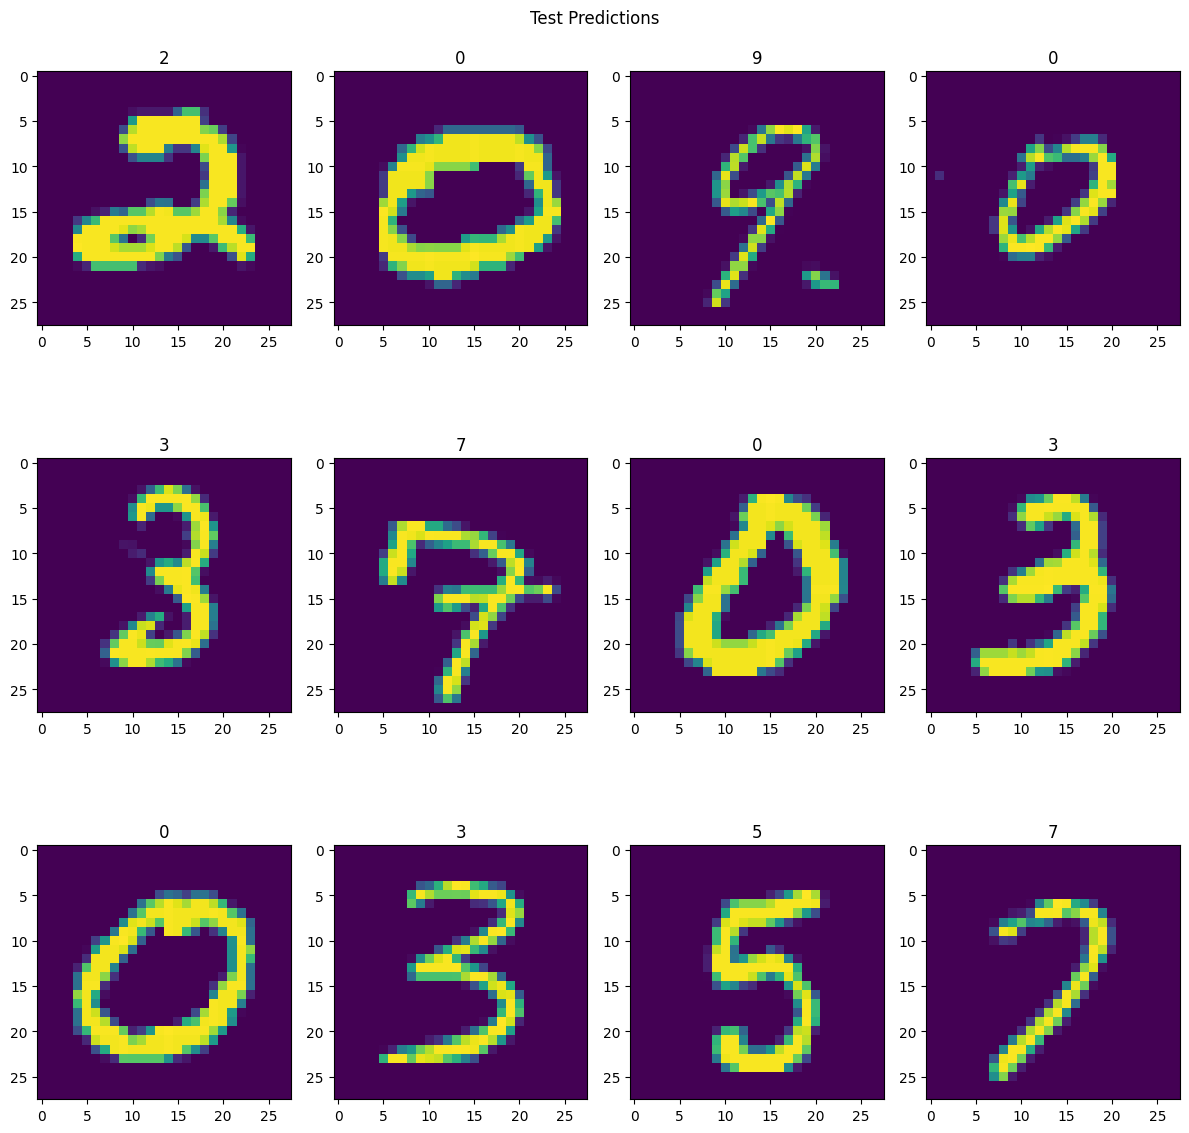

In [28]:
plot_digits(test_images, labels=test_predictions, title="Test Predictions")

In [29]:
output = pd.DataFrame({'ImageID': list(range(1, len(test_images)+1)),
                       'Label': test_predictions})
print(output.shape)
output.to_csv('submission.csv', index=False)
print("Submission File Created!!!!!!")

(28000, 2)
Submission File Created!!!!!!
